# Taller: Análisis de Tendencias para Google y Microsoft

En este taller analizaremos los datos de precios para Google y Microsoft (símbolos `GOOGL` y `MSFT`) utilizando la base `prices.csv`.

El objetivo es:

- Filtrar los datos para estas dos empresas.
- Convertir la columna de fecha de forma robusta, ya que diferentes empresas pueden tener distintos formatos de fecha.
- Ordenar los datos por fecha.
- Aplicar un suavizado (media móvil) para ver la tendencia general durante el periodo (máximo 2016).
- Generar una gráfica final que integre un storytelling (Setup, Conflict y Resolution) en el análisis de la tendencia.

Responde las siguientes preguntas en el proceso:

1. ¿Cuáles son el primer y último año del dataset para las empresas seleccionadas?
2. ¿Cuántas observaciones tienes para cada empresa?
3. ¿Qué tendencia se observa tras aplicar el suavizado?


In [6]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/time_series.zip
!unzip time_series.zip
!cp -r time_series/* ./

--2025-04-10 16:15:31--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/time_series.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/time_series.zip [following]
--2025-04-10 16:15:32--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/time_series.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15602616 (15M) [application/zip]
Saving to: ‘time_series.zip.1’

time_series.zip.1   100%[===================>]  14.88M  --.-KB/s    in 0.1s    

2025-04-10 16:15:32 (112 MB/s) - ‘tim

## Paso 1: Carga del Dataset y Filtrado de Empresas

Carga el archivo `prices.csv` y filtra únicamente los datos correspondientes a Google y Microsoft.

Pregunta: ¿Qué cantidad de observaciones tienes para cada empresa después del filtrado?

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('whitegrid')

# Load the dataframe
df = pd.read_csv('prices.csv') # This line is added to load the data

# Assuming the company symbols are in the 'symbol' column
empresas_interes = ['GOOGL', 'MSFT']
df_filtrado = df[df['symbol'].isin(empresas_interes)]

# Display the first few rows of the filtered DataFrame
(df_filtrado.head())

,date,symbol,open,close,low,high,volume
440,2010-01-04,GOOGL,626.950006,626.750011,624.240011,629.510005,3908400.0
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
908,2010-01-05,GOOGL,627.180001,623.990017,621.540016,627.839984,6003300.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1376,2010-01-06,GOOGL,625.860033,608.260035,606.360021,625.860033,7949400.0


In [8]:

conteo_empresas = df_filtrado['symbol'].value_counts()
(conteo_empresas)


,count
symbol,
GOOGL,1762
MSFT,1762


## Paso 2: Conversión Robust a Formato Datetime

Dado que diferentes empresas podrían tener formatos de fecha distintos, convertiremos la columna `date` usando `pd.to_datetime` sin forzar un formato fijo.

Elimina las filas que no se puedan convertir (donde la fecha es `NaT`).

Pregunta: ¿Cuántas filas se descartan por tener fechas inválidas?

In [9]:

df_filtrado['date'] = pd.to_datetime(df_filtrado['date'], errors='coerce')

df_filtrado = df_filtrado.dropna(subset=['date'])
print(df_filtrado['date'].isna().sum())


0


<ipython-input-9-47633875d99a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(df_filtrado['date'], errors='coerce')


No hay filas por tener fechas invalidas


## Paso 3: Ordenar Datos y Análisis Inicial

Ordena los datos por la columna `date` para cada empresa y determina:

- ¿Cuál es el primer año y el último año para cada empresa?
- ¿Cuántas observaciones hay en total para el periodo (recordando que la fecha máxima es 2016)?

In [10]:

df_filtrado = df_filtrado.sort_values(by=['symbol', 'date'])
rango_fechas = df_filtrado.groupby('symbol')['date'].agg(['min', 'max']).reset_index()
(rango_fechas)


,symbol,min,max
0,GOOGL,2010-01-04,2016-12-30
1,MSFT,2010-01-04,2016-12-30


In [11]:
df_hasta_2016 = df_filtrado[df_filtrado['date'].dt.year <= 2016]
total_observaciones = len(df_hasta_2016)
("Total de observaciones hasta 2016:", total_observaciones)


('Total de observaciones hasta 2016:', 3524)

## Paso 4: Visualización Inicial (Setup) – Gráfica de Precios de Cierre

Construye una gráfica inicial que muestre el precio de cierre a lo largo del tiempo para Google y Microsoft.

Utiliza un título multi-línea que comunique la etapa Setup. Por ejemplo:

```
Setup: Serie de Precios sin Suavizado
Datos originales para Google y Microsoft
CONFLICT: IDENTIFICAR MOVIMIENTOS ATÍPICOS
```

Pregunta: ¿Qué diferencias notas entre las series de ambas empresas?

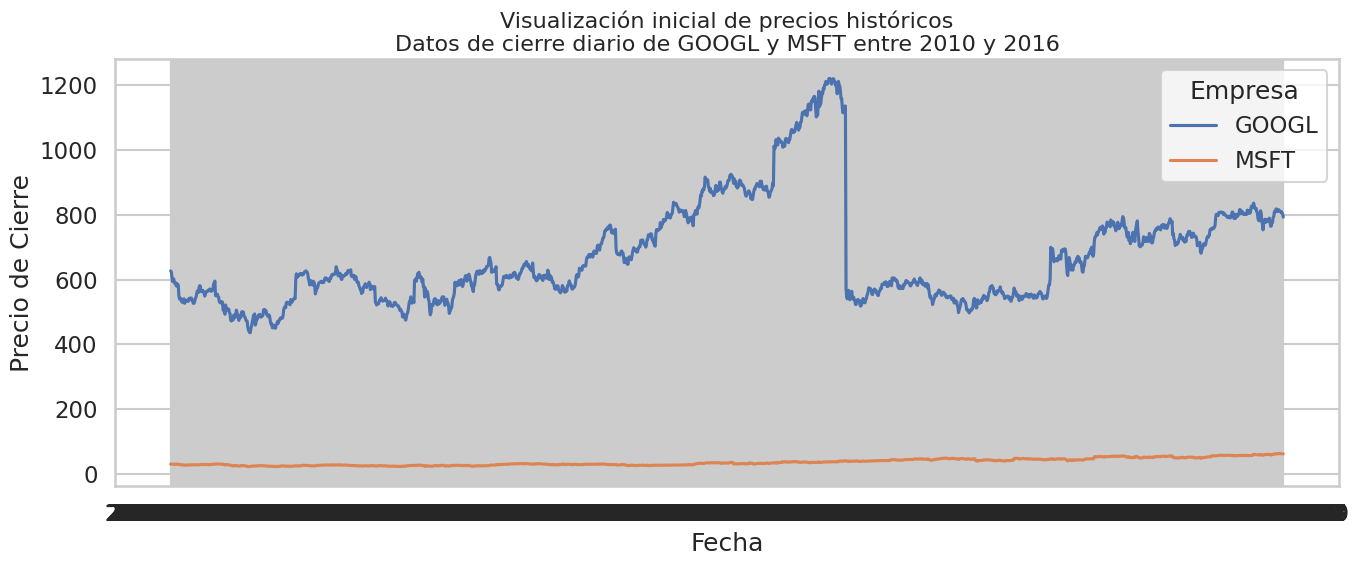

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 6))

sns.lineplot(data=df_filtrado, x='date', y='close', hue='symbol')

titulo = ("Visualización inicial de precios históricos\n"
          "Datos de cierre diario de GOOGL y MSFT entre 2010 y 2016")
plt.title(titulo, loc='center', fontsize=16)

plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre")
plt.legend(title='Empresa')

plt.tight_layout()
plt.show()


## Paso 5: Aplicar Suavizado (Resolution) – Media Móvil y Análisis de Tendencia

Aplica un suavizado a las series (por ejemplo, una media móvil) para resaltar la tendencia general en los datos.

Pregunta: ¿Qué ventana de suavizado (en días) consideras adecuada para observar la tendencia en el año 2016? ¿Cómo se comporta la tendencia para Google y Microsoft después de suavizar los datos?

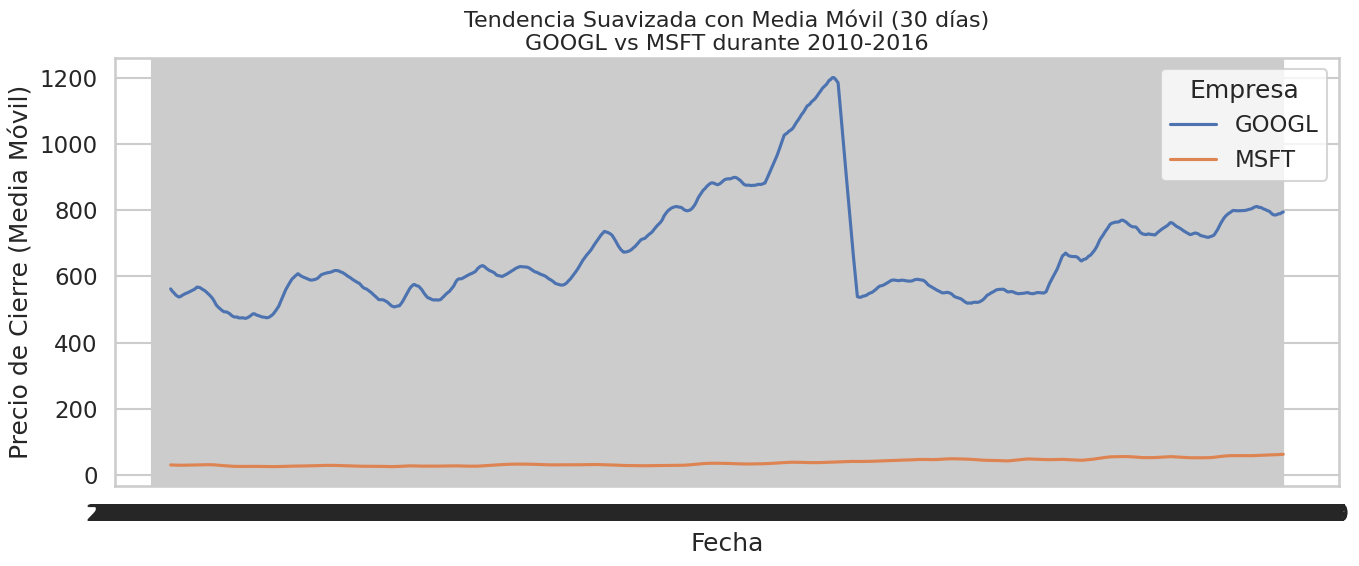

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", context="talk")

df_suavizado = df_filtrado.copy()
df_suavizado['close_smooth'] = df_suavizado.groupby('symbol')['close'].transform(lambda x: x.rolling(window=30).mean())

plt.figure(figsize=(14, 6))

sns.lineplot(data=df_suavizado, x='date', y='close_smooth', hue='symbol')

titulo = ("Tendencia Suavizada con Media Móvil (30 días)\n"
          "GOOGL vs MSFT durante 2010-2016")
plt.title(titulo, loc='center', fontsize=16)

plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (Media Móvil)")
plt.legend(title='Empresa')

plt.tight_layout()


Comportamiento de la tendencia (con 30 días) en 2016:
	•	Google (GOOGL): La tendencia suavizada muestra un crecimiento sostenido durante gran parte del año 2016, con una ligera estabilización hacia el último trimestre.
	•	Microsoft (MSFT): También muestra una tendencia creciente, aunque más moderada que GOOGL. La pendiente parece acelerarse hacia el final del año.

## Conclusiones y Entrega

En este taller se ha realizado lo siguiente:

- Se cargaron los datos y se filtraron únicamente para las empresas Google y Microsoft.
- Se convirtió la columna `date` de forma robusta, eliminando filas con fechas inválidas.
- Se ordenaron los datos cronológicamente y se obtuvieron información general (primer y último año, número de observaciones por empresa).
- Se construyó una gráfica de storytelling con dos etapas:
  - **Setup:** Visualización inicial de los precios de cierre originales para Google y Microsoft.
  - **Resolution:** Aplicación de un suavizado (media móvil) para resaltar la tendencia general.

Tu entrega final debe incluir las gráficas generadas y una breve explicación de cada paso, respondiendo las preguntas planteadas en el taller.